### Amazon Data Sales
Inlämningsuppgift 2: Anders Viklund BI23  
Deadline: 2024-02-11 23:59

### Data import

In [1]:
import time

# Get the current timestamp in seconds since the epoch
start_time = time.time()

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load dataset
df = pd.read_csv('AmazonDataSales.csv')
df.head(3)

C:\Users\ander\AppData\Local\Temp\ipykernel_24460\5467653.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AmazonDataSales.csv')


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


### Transformation steps

In [4]:
# Get info about dataset
#df.info()

# Convert Amount to log
df['Amount'] = np.log1p(df['Amount'])

# Delete rows where Amount == 0
df = df[df['Amount'] != 0]

# Delete rows where Amount == NaN
df = df[df['Amount'].notna()]

# Delete rows where Qty == 0
df = df[df['Qty'] != 0]

# Delete rows where Status == Cancelled
df = df[df['Status'] != 'Cancelled']





In [5]:
# Function to Count null values

def count_nulls(df):

    num_rows = df.shape[0]

    data = {
        'Column': [],
        'Non-Null Count': [],
        'Dtype': []
    }

    for column in df.columns:
        data['Column'].append(column)
        data['Non-Null Count'].append(df[column].count())
        data['Dtype'].append(df[column].dtype)

    info_df = pd.DataFrame(data)

    info_df['Null Count'] = num_rows - info_df['Non-Null Count']

    info_df['Percentage'] = ((info_df['Null Count']/num_rows)*100).round(2)

    columns_disp = ['Column','Dtype','Non-Null Count','Null Count','Percentage']

    #Sorting
    column_name = 'Percentage'
    info_df_sorted = info_df.sort_values(by=column_name, ascending=False)

    return info_df_sorted[columns_disp].head(10)


In [6]:
count_nulls(df)

,Column,Dtype,Non-Null Count,Null Count,Percentage
22,fulfilled-by,object,31589,76482,70.77
23,Unnamed: 22,object,67069,41002,37.94
20,promotion-ids,object,78675,29396,27.20
19,ship-country,object,108045,26,0.02
18,ship-postal-code,float64,108045,26,0.02
17,ship-state,object,108045,26,0.02
16,ship-city,object,108045,26,0.02
1,Order ID,object,108071,0,0.00
21,B2B,bool,108071,0,0.00
15,Amount,float64,108071,0,0.00


In [7]:
# Relevant columns
columns_to_keep = ['Category','Size','Qty','Amount']

df = df[columns_to_keep]

In [8]:
# Check if there are null values

count_nulls(df)

,Column,Dtype,Non-Null Count,Null Count,Percentage
0,Category,object,108071,0,0.0
1,Size,object,108071,0,0.0
2,Qty,int64,108071,0,0.0
3,Amount,float64,108071,0,0.0


In [9]:
# Toggle between imputing with mean or deleting rows

deleting_rows = True

mean_value = df['Amount'].mean()

if deleting_rows:
    df = df.dropna(subset=['Amount'])
    print(len(df))
else:
    df['Amount'] = df['Amount'].fillna(mean_value)
    print(len(df))


108071


In [10]:
# One-hot encoding on categorical columns Category and Size

df_encoded = pd.get_dummies(df, columns=['Category','Size'])

# Get bool columns
bool_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'bool']

# Convert bool columns to int
for i in bool_cols:
    df_encoded[i] = df_encoded[i].astype(int)

In [11]:
# Prepare result df

data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}



### Linear regression

In [12]:
# Features and Target
X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Decision Tree regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = regression_model.predict(X_test)

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Add new values for prediction
new_data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}

new_data['Model'].append('Linear Regression')
new_data['Mean Squared Error'].append(mse)
new_data['R-squared'].append(r2)

data['Model'].extend(new_data['Model'])
data['Mean Squared Error'].extend(new_data['Mean Squared Error'])
data['R-squared'].extend(new_data['R-squared'])


### KNN

In [13]:
# KNN from sklearn
from sklearn import neighbors

X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = neighbors.KNeighborsRegressor(n_neighbors=15)

clf.fit(X_train,y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Add new values for prediction
new_data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}

new_data['Model'].append('KNN Regression')
new_data['Mean Squared Error'].append(mse)
new_data['R-squared'].append(r2)

data['Model'].extend(new_data['Model'])
data['Mean Squared Error'].extend(new_data['Mean Squared Error'])
data['R-squared'].extend(new_data['R-squared'])



### Decision tree

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeRegressor

# Build and train the Decision Tree regression model
regression_model = DecisionTreeRegressor(random_state=42)
regression_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = regression_model.predict(X_test)

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Add new values for prediction
new_data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}

new_data['Model'].append('Decision Tree Regression')
new_data['Mean Squared Error'].append(mse)
new_data['R-squared'].append(r2)

data['Model'].extend(new_data['Model'])
data['Mean Squared Error'].extend(new_data['Mean Squared Error'])
data['R-squared'].extend(new_data['R-squared'])

### XGBoost

In [15]:
# Import necessary libraries
import xgboost as xgb
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
#boston = load_boston()
X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Add new values for prediction
new_data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}

new_data['Model'].append('XGBoost Regression')
new_data['Mean Squared Error'].append(mse)
new_data['R-squared'].append(r2)

data['Model'].extend(new_data['Model'])
data['Mean Squared Error'].extend(new_data['Mean Squared Error'])
data['R-squared'].extend(new_data['R-squared'])


Mean Squared Error: 0.07
R-squared: 0.55


### Random forest

In [16]:
# Import necessary libraries
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
#boston = load_boston()

X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Add new values for prediction
new_data = {
    'Model': [],
    'Mean Squared Error': [],
    'R-squared': []    
}

new_data['Model'].append('Random Forest Regression')
new_data['Mean Squared Error'].append(mse)
new_data['R-squared'].append(r2)

data['Model'].extend(new_data['Model'])
data['Mean Squared Error'].extend(new_data['Mean Squared Error'])
data['R-squared'].extend(new_data['R-squared'])

### Results

In [17]:
from datetime import datetime

print("End of script")

# Get the current timestamp in seconds since the epoch
stop_time = time.time()

# Get the current date and time
current_datetime = datetime.now()

elapsed = stop_time - start_time

print(f"Current time: {current_datetime}")
print(f"Elapsed time: {elapsed}")

result_df = pd.DataFrame(data)

result_df

End of script
Current time: 2024-02-11 20:45:19.302341
Elapsed time: 73.9864661693573


,Model,Mean Squared Error,R-squared
0,Linear Regression,0.066170,0.554204
1,KNN Regression,0.071665,0.517188
2,Decision Tree Regression,0.066140,0.554406
3,XGBoost Regression,0.066142,0.554392
4,Random Forest Regression,0.066144,0.554382


Comment: <br>
None of the models gave a really good prediction score but I will evalutate one of the models in order to find out why

### Evaluation of Decision Tree Model

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

X = df_encoded.drop('Amount', axis=1)

y = df_encoded['Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Decision Tree regression model
regression_model = DecisionTreeRegressor(random_state=42)
regression_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = regression_model.predict(X_test)

#### Actual vs predicted plot

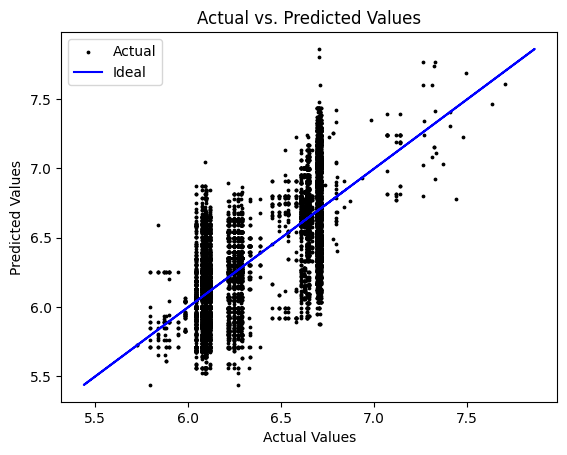

In [19]:
# Visualize the predictions

# ideal prediction is when y_pred = y_test

ideal = y_test

plt.scatter(y_pred, y_test, color='black', label='Actual', s=3)
plt.plot(ideal, y_test, color='Blue', label='Ideal')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(loc='upper left')
plt.show()

np.savetxt('y_pred.csv', y_pred, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')


If the model makes good predictions, the data points should be aligned to the blue line. <br>
There are some dense clusters to look into. The data points are equally numbered over and under the line. <br>
Meaning that the model is not over or under estimating the predicted value systematically.

In [20]:
# Number of data points above and below the line

count_above = 0
count_below = 0

nrows = len(y_pred)

y_test_list = y_test.tolist()
y_pred_list = y_pred.tolist()

for i in range(nrows):

    if(y_test_list[i] < y_pred_list[i]):
        count_above += 1
    elif(y_test_list[i] > y_pred_list[i]):
        count_below += 1

# Diff

percent = (count_above/nrows)*100

percent = round(percent, 2)

print(f"Number of data points above the line: {count_above} ({percent}%)")





Number of data points above the line: 11361 (52.56%)


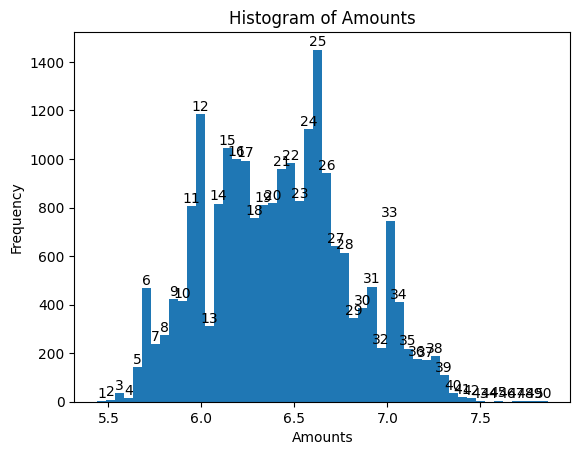

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'amounts' is your dataset
amounts = y_test

# Plot the histogram and capture the output
counts, bin_edges, patches = plt.hist(amounts, bins=50)

# Label each bin with its number
for i in range(len(patches)):
    # Calculate the position for the bin label
    bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
    # Use the count as the y position
    label_position_y = counts[i] + (max(counts) * 0.01)  # Adjust the offset as needed
    
    # Add bin number label
    plt.text(bin_center, label_position_y, str(i+1), ha='center')

plt.xlabel('Amounts')
plt.ylabel('Frequency')
plt.title('Histogram of Amounts')
plt.show()


After the log transformation of Amount the histogram shows as more normally distributed. Before the histogram was heavily skewed tailing to the right.

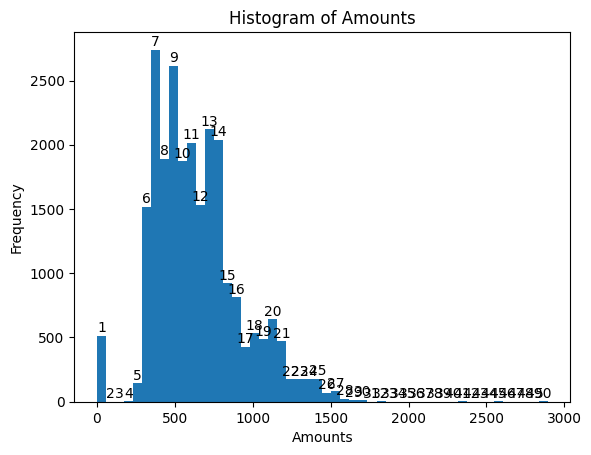

In [22]:
from IPython.display import Image

Image(filename='amount_hist.png', width=500) 

#### Residual analysis

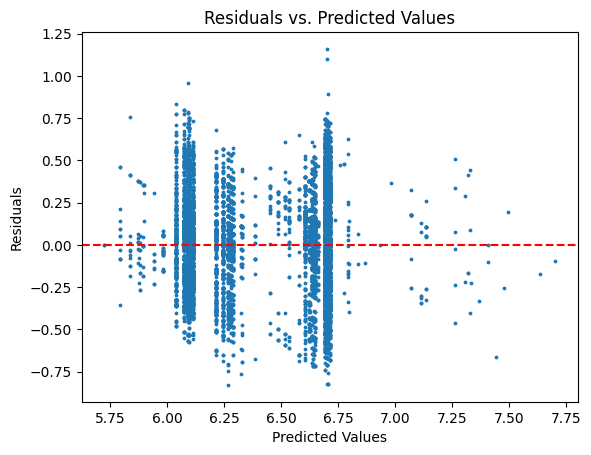

In [23]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.scatter(y_pred, residuals, s=3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.show()


Ideally the residuals should be close to the red dashed line, indicating a good fit for the model. <br>
Here we can see that they are quite widely spread from the line

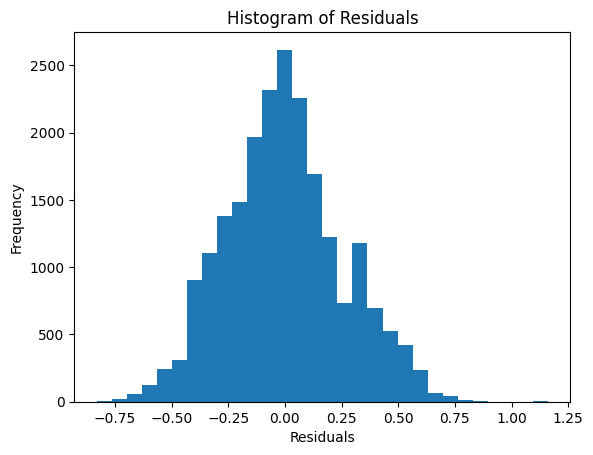

In [24]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


The histogram should be normally distributed. Skewness indicate issues with the model. <br>
I would say that the histogram is not skewed, it has a fairly gaussian form.

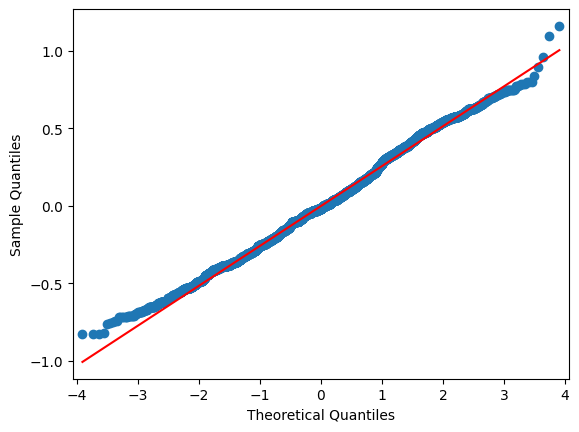

In [25]:
import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.show()


For the residuals to be normally distributed the points should aligned to the red line. <br>
The deviation from the line at low and high x values are much better now due to the transfomation steps <br>
see below graph for comparison before and after

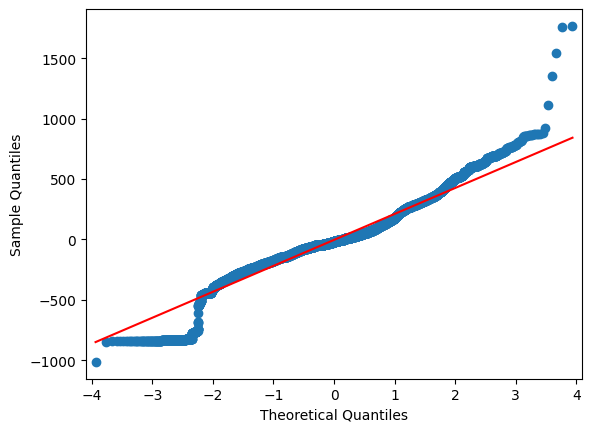

In [26]:
from IPython.display import Image

Image(filename='before transformation.png', width=500) 

### Conclusion

None of the models I trained on the dataset performed well to predict the Amount. The best method (Decision Tree Regression) gave an R2 value of 0.41.
I evaluated the result in order to assess if there was a problem with the model or the data. After implementing some transformation steps I could crank up the R2 value to 0.55.
Still not a good result but the evaluation gave me insight in how specific parts of the data affect the model.

In [27]:
result_df

,Model,Mean Squared Error,R-squared
0,Linear Regression,0.066170,0.554204
1,KNN Regression,0.071665,0.517188
2,Decision Tree Regression,0.066140,0.554406
3,XGBoost Regression,0.066142,0.554392
4,Random Forest Regression,0.066144,0.554382
